Import python packages to be used

In [1]:
import random, numpy as np, math, copy, matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
#from google.colab import files
from tqdm import tqdm
from numba import njit
from numba.typed import List

Create a list of random cities to be used as the dataset for TSP

In [2]:

#create list of 50 random cities. Probably need to make this a 2d array with an x,y component. 
cities = [random.sample(range(100), 2) for x in range(50)];
print(cities)

#tour = random.sample(range(50),50);
#print(tour) some edit here by NB

#Generate a distance matrix from the list of 50 cities
df = pd.DataFrame(cities, columns=['xcord', 'ycord'])
cities_distance_matrix = distance_matrix(df.values, df.values)
#cities_distance_matrix2 = distance_matrix()

#Randomly select a city to start at for both algorithms
root = random.randint(0,49) #Randomly select one vertex as the root.
print(cities_distance_matrix)

[[91, 37], [43, 95], [82, 76], [58, 92], [90, 9], [80, 18], [64, 16], [69, 10], [54, 66], [58, 4], [19, 13], [41, 49], [11, 56], [36, 62], [68, 23], [5, 27], [86, 9], [14, 24], [50, 20], [2, 9], [10, 41], [75, 43], [47, 21], [83, 10], [1, 68], [37, 20], [84, 35], [41, 33], [30, 89], [79, 12], [12, 61], [90, 16], [35, 0], [54, 74], [93, 67], [19, 24], [24, 22], [31, 50], [48, 32], [46, 33], [59, 32], [30, 17], [54, 26], [73, 88], [12, 59], [62, 88], [3, 65], [97, 69], [48, 97], [2, 93]]
[[  0.          75.2861209   40.02499219 ...  32.55764119  73.81734214
  105.15227054]
 [ 75.2861209    0.          43.38202393 ...  59.93329626   5.38516481
   41.0487515 ]
 [ 40.02499219  43.38202393   0.         ...  16.55294536  39.96248241
   81.78630692]
 ...
 [ 32.55764119  59.93329626  16.55294536 ...   0.          56.43580424
   97.98469268]
 [ 73.81734214   5.38516481  39.96248241 ...  56.43580424   0.
   46.17358552]
 [105.15227054  41.0487515   81.78630692 ...  97.98469268  46.17358552
    0.

Update Methods: 

*   as_pheroupdate: Ant System Update, S*upd* <- S*iter*
*   ib_pheroupdate: Iteration Best Update, S*upd* <- arg max F(s) (to avoid premature converence, best 10(?) will be used)



In [3]:
#Ant System Update
@njit
def as_pheroupdate(pheromone_maxtix,s_iter,total_list):
   for index in range(len(total_list)):
    #print(s_iter[index])
    for jdex in range(len(s_iter[index])-1):
      x = s_iter[index][jdex]
      y = s_iter[index][jdex+1]
      pheromone_maxtix[x][y] += 1/total_list[index]

In [4]:
#Iteration Best Update
@njit
def ib_pheroupdate(pheromone_maxtix,s_iter,total_list):
  sort_index = np.argsort(np.asarray(total_list))
  #print(sort_index)
  #print(np.sort(vals))
  for index in range(10):
    for jdex in range(len(s_iter[index])-1):
      x = s_iter[sort_index[index]][jdex]
      y = s_iter[sort_index[index]][jdex+1]
      pheromone_maxtix[x][y] += 1/total_list[sort_index[index]]

In [5]:
@njit
def delete_workaround(arr, num):
    mask = np.zeros(arr.shape[0], dtype=np.int64) == 0
    mask[np.where(arr == num)[0]] = False
    return arr[mask]


Ant Colony Optimization using adjacency matrices

In [6]:
#Start of ACO algo


@njit
def aco_func(pheromone_maxtix,ants,alpha,update_func):
  s_iter = List()
  total_list = List()
  beta = 0.1
  for i in range(ants):
    total = 0.0;
    currentlocation = root
    s = List()
    s.append(root)
    canVisit = np.arange(50)
    #canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
    canVisit = delete_workaround(canVisit, currentlocation)
    #print("start")
    while len(canVisit) !=0:
      probSum = 0
      probList = list()
      for value in canVisit:
        prob = (pheromone_maxtix[currentlocation][value] ** alpha) * ((1/cities_distance_matrix[currentlocation][value]) ** beta)
        probSum += prob
      if (probSum == 0):
        newcity = np.random.choice(canVisit)
      else:
        for value in canVisit:
          prob = ((pheromone_maxtix[currentlocation][value] ** alpha) * ((1/cities_distance_matrix[currentlocation][value]) ** beta)) / probSum
          probList.append(prob)
        cumulative_distribution = np.cumsum(np.asarray(probList))
        cumulative_distribution /= cumulative_distribution[-1]
        uniform_samples = np.random.rand(len(canVisit))
        index = np.searchsorted(cumulative_distribution, uniform_samples, side="right")
        newcity = canVisit[index[0]]
        
      #print("newcity:")
      #print(newcity)
      s.append(newcity)
      total += cities_distance_matrix[currentlocation][newcity]
      currentlocation = newcity
      canVisit =  delete_workaround(canVisit, currentlocation)

    s.append(root)
    total += cities_distance_matrix[root][currentlocation]  
    total_list.append(total)
    s_iter.append(s)

  #Pheromone Update
  update_func(pheromone_maxtix,s_iter,total_list)

Parameters for ACO

In [7]:
maxIterations = 10000
ants= 50
alpha = 1

Initialize Pheromone Matrix

In [8]:
pheromone_maxtix = np.zeros(shape=(50,50))

(Optional) Load a list of cities and their corresponding pheromone matrix from a spreadsheet

In [9]:
url = 'https://raw.githubusercontent.com/ChristianVaughn/BioInspiredML/main/TSP/Dataset3/cities.csv?token=AHSGZY7FU5YPWMREIOXE6ADANYSAW'
citiestemp = pd.read_csv(url)
citiestemp = citiestemp.loc[:, ~citiestemp.columns.str.contains('^Unnamed')]
root = citiestemp.tail(1).iloc[0,2] #citiestemp.loc[:,'root']
citiestemp = citiestemp.loc[:, ~citiestemp.columns.str.contains('^root')]
citiestemp = citiestemp.dropna()
cities = citiestemp.values.tolist()
for x in range(len(cities)):
  for y in range(2):
    cities[x][y] = int(cities[x][y])
root = int(root)
#Generate a distance matrix from the list of 50 cities
df = pd.DataFrame(cities, columns=['xcord', 'ycord'])
cities_distance_matrix = distance_matrix(df.values, df.values)
print(cities)

[[63, 54], [77, 31], [86, 2], [94, 25], [13, 56], [41, 37], [74, 89], [28, 59], [54, 32], [57, 27], [27, 10], [82, 62], [10, 12], [35, 90], [70, 98], [35, 48], [9, 61], [2, 57], [11, 84], [83, 62], [64, 83], [46, 72], [98, 71], [14, 35], [91, 84], [11, 49], [22, 78], [0, 53], [99, 47], [19, 37], [63, 89], [8, 74], [98, 65], [58, 33], [49, 36], [35, 40], [17, 58], [50, 94], [93, 74], [33, 76], [51, 63], [22, 0], [11, 99], [10, 4], [34, 20], [21, 51], [44, 80], [39, 50], [50, 64], [90, 89]]


Pheromone Matrix for AS update

In [ ]:

#url = 'https://raw.githubusercontent.com/ChristianVaughn/BioInspiredML/main/TSP/Dataset3/pheromone_matrix_asupdate.csv?token=AHSGZY65WPDXYGXED3GKKX3AOI6G6' #old url
url = 'https://raw.githubusercontent.com/ChristianVaughn/BioInspiredML/main/TSP/Dataset3/pheromone_matrix_asupdate_Fixed.csv?token=AHSGZYZ2EVAQEEAD7A5KFEDAONSRM'
pmatrix = pd.read_csv(url)
pheromone_maxtix = pmatrix.loc[:, ~pmatrix.columns.str.contains('^Unnamed')]
pheromone_maxtix.index = range(50)
pheromone_maxtix.columns = range(50)

Pheromone Matrix for IB update

In [ ]:
#url = 'https://raw.githubusercontent.com/ChristianVaughn/BioInspiredML/main/TSP/Dataset3/pheromone_matrix_ibupdate.csv?token=AHSGZY2TUHILZBKWSAHTNH3AOI6HC'#old data
url = 'https://raw.githubusercontent.com/ChristianVaughn/BioInspiredML/main/TSP/Dataset3/pheromone_matrix_ibupdate_Fixed.csv?token=AHSGZYZ7NLEAGDNN55P2HJTAOM7TE' #new data
pmatrix = pd.read_csv(url)
pheromone_maxtix = pmatrix.loc[:, ~pmatrix.columns.str.contains('^Unnamed')]
pheromone_maxtix.index = range(50)
pheromone_maxtix.columns = range(50)

Click to run ACO algorithm for the specified number of iterations

In [10]:
for iteration in tqdm(range(maxIterations)):
  aco_func(pheromone_maxtix,ants,alpha,ib_pheroupdate)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:37<00:00, 102.38it/s]


In [11]:
pheromone_maxtix

array([[ 0.        ,  2.10087536,  0.75570221, ...,  4.06849558,
         3.97795772,  0.25995538],
       [11.15704169,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.34005068],
       [ 2.08325098,  2.9914591 ,  0.        , ...,  0.16848055,
         1.34158081,  0.16688328],
       ...,
       [ 1.95508479,  1.47063668,  1.34156192, ...,  0.        ,
         3.8820819 ,  0.11342975],
       [ 2.81442426,  1.23648338,  0.91077767, ...,  7.24021318,
         0.        ,  0.32322228],
       [ 1.6738578 ,  1.64247954,  0.62820202, ...,  0.04652348,
         2.05816191,  0.        ]])

(Optional) Store the list of cities and pheromone matrix to text files

In [ ]:
tempdf = pd.DataFrame(cities,columns=['x','y'])
tempdf = tempdf.append(pd.DataFrame([root],columns=['root']))
tempdf.to_csv('cities.csv')
files.download('cities.csv')  #download the csv file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pheromone_maxtix.to_csv('pheromone_matrix.csv') #stores pheromone matrix as a csv file that can be downloaded
files.download('pheromone_matrix.csv')  #download the csv file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finding 5 of the most optimal paths using the pheromone matrix

In [20]:
def aco_results():
  s_iter = []
  total_list = []
  beta = 0.1
  for i in range(5):
    total = 0.0;
    currentlocation = root
    s = []
    s.append(root)
    canVisit = np.array(range(50))
    canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
    #print("start")
    while len(canVisit) !=0:
      probSum = 0
      probList = list()
      for value in canVisit:
        prob = (pheromone_maxtix[currentlocation][value] ** alpha) * ((1/cities_distance_matrix[currentlocation][value]) ** beta)
        probSum += prob
      if (probSum == 0):
        newcity = np.random.choice(canVisit)
      else:
        for value in canVisit:
          prob = ((pheromone_maxtix[currentlocation][value] ** alpha) * ((1/cities_distance_matrix[currentlocation][value]) ** beta)) / probSum
          probList.append(prob)
        newcity = np.random.choice(canVisit, p=probList)
        
      #print("newcity:")
      #print(newcity)
      s.append(newcity)
      total += cities_distance_matrix[currentlocation][newcity]
      currentlocation = newcity
      canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))

    s.append(root)
    total += cities_distance_matrix[root][currentlocation]  
    total_list.append(total)
    s_iter.append(s)
  return s_iter,total_list

Heuristic Algorithm - Nearest Neighbor

Find the vertex that is closest (more precisely, has the lowest cost) to the current position but is not yet part of the route, and add it into the route.
Repeat until the route includes each vertex.

In [29]:
#Heuristic algo - nearest neighbor
currentlocation = root  #start at the randomly determined starting city
total = 0   #counter for the total distance in the path taken
route = []    #list to store the path taken
canVisit = np.array(range(50))
canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
route.append(currentlocation) #append the starting position to the route

#Each of the cities will be visited once, with the exception of the starting city, which we will return to
for i in range(len(cities)-1):
  nextlocation = -1
  min = np.Inf
  for value in canVisit:
    if cities_distance_matrix[currentlocation][value] < min:
      min = cities_distance_matrix[currentlocation][value]
      nextlocation = value
  #nextlocation = np.amin(cities_distance_matrix[currentlocation]) #using the adjacency matrix, finds the smallest value and returns the next city to be visited
  canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
  total += cities_distance_matrix[currentlocation][nextlocation] #adds the distance between the current city and the next city to the total
  route.append(nextlocation) #appends the next city to the route
  currentlocation = nextlocation #sets the current location to the next location
  canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation)) #drops the current city from the adjacency matrix since it can no longer be visited (with the exception of the return to the starting city)

#return to the starting location at the end
total += cities_distance_matrix[root][currentlocation] #find the distance from the last city visited to the starting location 
route.append(root) #append the starting location to the route

In [30]:
print(route)
print(total)


[1, 3, 28, 32, 22, 38, 24, 49, 6, 14, 30, 20, 37, 46, 21, 48, 40, 0, 11, 19, 33, 8, 9, 34, 5, 35, 15, 47, 7, 45, 36, 4, 16, 17, 27, 25, 23, 29, 44, 10, 41, 43, 12, 31, 18, 26, 39, 13, 42, 2, 1]
748.2254809647552


Graph Stuff

In [18]:
def sortCitiesSolution(lst):
    global cities
    x = []
    y = []
    for val in lst:
        x.append(cities[val][0])
        y.append(cities[val][1])
    return (x,y)
    

Nearest Neighbor stuff

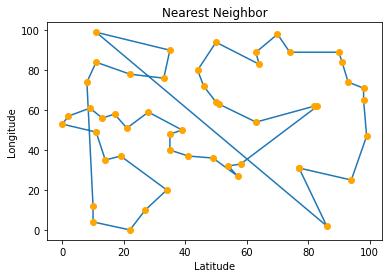

In [48]:
nearestNeighborX,nearestNeighborY = sortCitiesSolution(route)
fig,ax = plt.subplots()
plt.scatter(nearestNeighborX,nearestNeighborY ,color='orange',zorder=1)
plt.plot(nearestNeighborX,nearestNeighborY ,zorder=0)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_title('Nearest Neighbor')
#plt.set_xticks(ind)
fig.savefig("nearestneighbor.png")
plt.show()

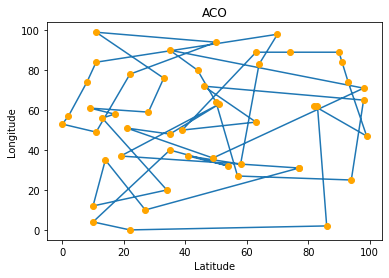

route:[1, 10, 23, 12, 44, 4, 36, 16, 7, 39, 42, 37, 26, 25, 27, 17, 31, 18, 14, 20, 33, 5, 8, 35, 43, 41, 2, 19, 11, 28, 38, 24, 49, 6, 30, 47, 0, 21, 32, 3, 9, 48, 46, 13, 22, 34, 45, 15, 40, 29, 1]
cost:1441.3775952188796


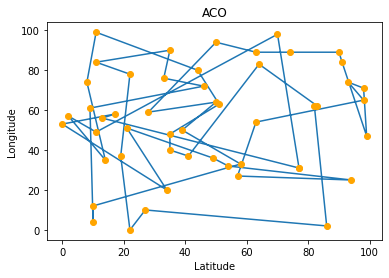

route:[1, 14, 25, 17, 23, 31, 42, 46, 40, 15, 35, 5, 20, 19, 11, 2, 10, 41, 29, 26, 18, 13, 39, 21, 16, 43, 12, 33, 47, 48, 7, 37, 30, 6, 49, 24, 28, 22, 38, 32, 0, 9, 3, 8, 34, 45, 44, 27, 36, 4, 1]
cost:1433.0554007110431


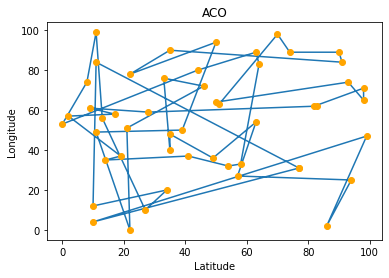

route:[1, 43, 28, 2, 3, 9, 0, 34, 15, 35, 39, 21, 45, 41, 25, 47, 37, 26, 13, 24, 49, 6, 14, 40, 48, 38, 32, 22, 11, 19, 7, 16, 36, 17, 29, 23, 5, 8, 33, 20, 30, 46, 27, 31, 42, 4, 10, 44, 12, 18, 1]
cost:1507.9344587112664


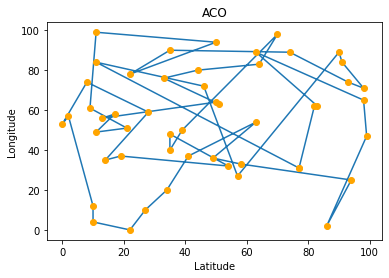

route:[1, 11, 19, 30, 32, 28, 2, 3, 33, 34, 0, 5, 44, 10, 41, 43, 12, 17, 27, 31, 7, 23, 29, 8, 15, 35, 47, 14, 20, 46, 39, 40, 48, 4, 36, 25, 45, 16, 42, 37, 26, 13, 6, 38, 22, 24, 49, 9, 21, 18, 1]
cost:1229.0747521858268


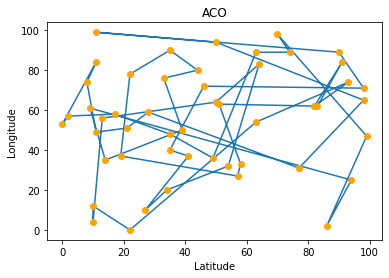

route:[1, 7, 45, 25, 31, 18, 27, 17, 36, 15, 34, 30, 6, 14, 28, 2, 3, 16, 23, 47, 39, 46, 13, 26, 29, 9, 33, 40, 19, 24, 11, 38, 0, 41, 12, 43, 4, 48, 20, 8, 44, 10, 5, 35, 21, 22, 49, 42, 37, 32, 1]
cost:1527.6103271500733


In [21]:
s_iter,total_list = aco_results()
for index in range(len(s_iter)):
  acoCityX,acoCityY = sortCitiesSolution(s_iter[index])
  fig,ax = plt.subplots()
  plt.scatter(acoCityX,acoCityY ,color='orange',zorder=1)
  plt.plot(acoCityX,acoCityY ,zorder=0)
  ax.set_ylabel('Longitude')
  ax.set_xlabel('Latitude')
  ax.set_title('ACO')
  #plt.set_xticks(ind)
  fig.savefig("aco.png")
  plt.show()
  print('route:', end='')
  print(s_iter[index])
  print('cost:', end='')
  print(total_list[index])